# Scalable Recommendation with Poisson Factorization - Computation Statistics Project 1
#### The following notebook is an example of the use of the implementation of the mean-field variational algorithm for approximate posterior inference for the Hierarchical Poisson Factorization, by Gopalan et al. (2013).

The variational inference algorithm for HPF has been implemented and stored in the module **hpf_vi**.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import scipy.stats
import sklearn.metrics
from hpf_vi import hpf_vi
from sklearn.metrics import mean_squared_error

The dataset is a sparse matrix of 0 and 1, which represents the interaction between users and items.

The matrix contains clusters of similar users in terms of items consumed. There are more than 1700 users and approximately 17000 items.

In [0]:
ratings = pd.read_pickle("ratings_df.pkl")
ratings = np.array(ratings)

As one can read in the documentation of **hpf_vi**, the algorithm stops either when the difference between two subsequent log-likelihood is smaller than a tolerance value (which can be changed) or after a user-defined number of iterations.

In the following code, a function that splits training and testing data is defined.

As suggested by the authors of the paper, the test set consists of randomly selected ratings, which are set to zero during the training. In the original paper, the algorithm convergence is ultimately evaluated on the evaluation set.

In [0]:
def train_val_split(data, valid_dim=0.2):
        '''
        Creating two additional objects, i.e. training and validation set, which can be used in the fitting process

        Parameters:
        data = np.array
        valid_dim = float
        '''
        if valid_dim >= 1:
          raise ValueError("valid_dim must be lower than 1")

        train = data.copy()
        valid = np.zeros(data.shape)

        for u in np.unique(data.nonzero()[0]):
            ind = data[u].nonzero()[0] 

            if len(ind) > 0: 
                valid_ind = np.random.choice(ind, round(len(ind)*valid_dim), replace=False)
                for i in valid_ind:
                    valid[u,i], train[u,i] = data[u,i], 0
        return train, valid


In [0]:
train, valid = train_val_split(ratings)

We can now fit the model using the variational inference algorithm. Note that the specification of a validation set is optional.


In [0]:
model = hpf_vi() # instantiating the model
model.fit(train = train, valid = valid, tol = 1, iterations = 100)

/content/hpf_vi.py:180: RuntimeWarning: divide by zero encountered in log
  self.logprod = np.log(self.prod)


Iteration 1 completed. Log-likelihood: -490615.3103000939
Iteration 2 completed. Log-likelihood: -323015.23834610434
Iteration 3 completed. Log-likelihood: -318774.2976711654
Iteration 4 completed. Log-likelihood: -313930.70678088063
Iteration 5 completed. Log-likelihood: -308607.27008250845
Iteration 6 completed. Log-likelihood: -303053.3607144351
Iteration 7 completed. Log-likelihood: -297630.4992321108
Iteration 8 completed. Log-likelihood: -292810.58741591265
Iteration 9 completed. Log-likelihood: -288748.36091322475
Iteration 10 completed. Log-likelihood: -285378.72530929407
Iteration 11 completed. Log-likelihood: -282643.4547582964
Iteration 12 completed. Log-likelihood: -280459.37213482906
Iteration 13 completed. Log-likelihood: -278699.8936695267
Iteration 14 completed. Log-likelihood: -277234.0055183092
Iteration 15 completed. Log-likelihood: -275966.0447572188
Iteration 16 completed. Log-likelihood: -274847.70482325467
Iteration 17 completed. Log-likelihood: -273867.713356175

As one can see in the next graph, the log-likelihood, as expected, tends to a higher value, until one of the two stopping criteria is met.
Recall that the log-likelihood is the following:
$$
p(y) = \prod_{u,i}\frac{(\theta_u^T\beta_i)^{y_{u,i}}\cdot e ^{-\theta_u^T\beta_i}}{y_{u,i}!} = \prod_{u,i:\;y_{u,i} > 0} \frac{(\theta_u^T\beta_i)^{y_{u,i}}}{y_{u,i}!} \cdot \prod_{u,i} e ^{-\theta_u^T\beta_i}
$$

Text(0, 0.5, '- Loglikelihood')

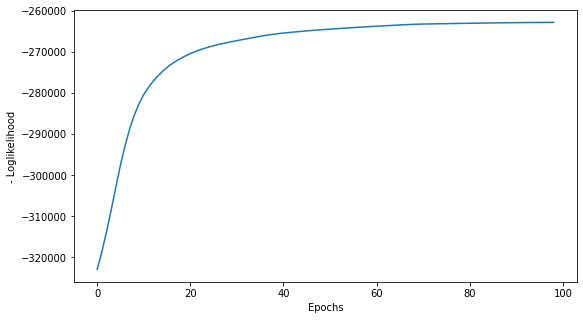

In [0]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(model.ll[1:model.its]) # trimming the loglik computed on the random initialization
ax.set_xlabel("Epochs")
ax.set_ylabel("- Loglikelihood")

The **fit** method will generate a sequence of Mean Squared Errors for both the training and, if provided, the validation set. This second parameter can be used, as suggested by the authors, as a stopping criterion for the algorithm. Nevertheless, we opt for the in-sample log-likelihood.

In the following, a graph of the MSE for the validation and the training set is plotted as function of the number of iterations.

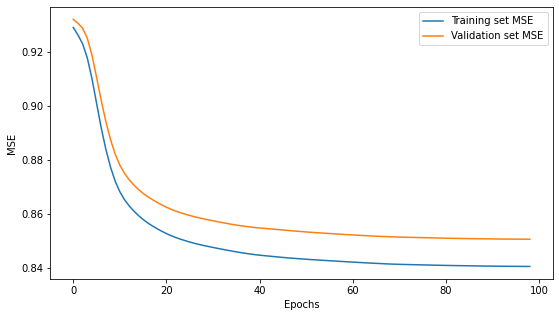

In [0]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(model.mse_train[1:model.its],label="Training set MSE")
ax.plot(model.mse_valid[1:model.its], label="Validation set MSE")
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE")
ax.legend();

Recommendations can now be made thanks to the estimated parameter. The method **recommend** suggests, for each user, the items that obtained the highest score.

## Plotting some results ##
In the following, we can qualitatively assess the in-sample performance of the model by comparing the actual vs predicted observations for 3 users of our dataset.

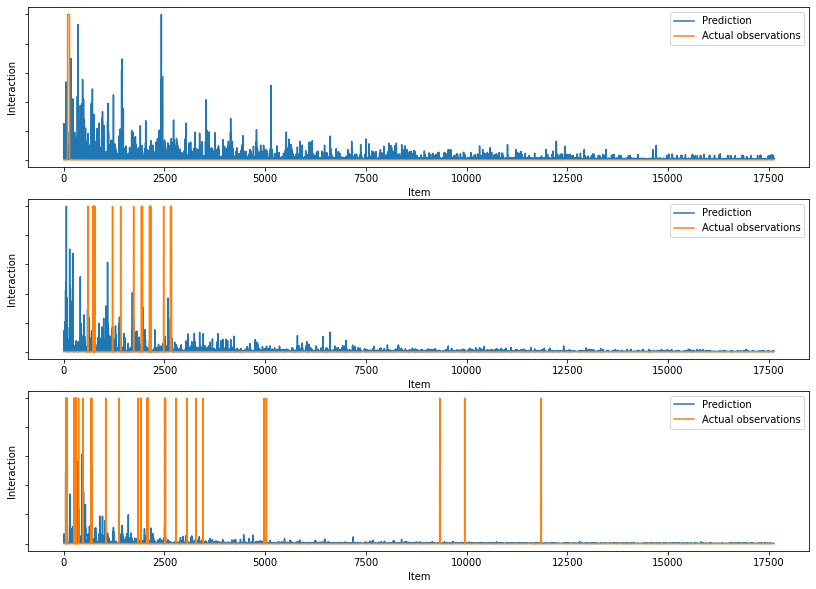

In [0]:
fig, ax = plt.subplots(figsize=(14, 10), nrows=3)

for u,i in enumerate([1,100,1000]):
    ax[u].plot(model.predicted[i]/model.predicted[i].max(), label = "Prediction")
    ax[u].plot(ratings[i], label = "Actual observations")
    ax[u].set_xlabel("Item")
    ax[u].set_ylabel("Interaction")
    ax[u].set_yticklabels([])
    ax[u].legend();